In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel("/content/drive/MyDrive/ML_3/train.xlsx")
df.head(10)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


Сортируем датасет, чтобы лаги были корректными

In [3]:
df = df.sort_values(by='dt').reset_index(drop=True)
df

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


In [4]:
df.shape

(400, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


нулевых значений нет

<Axes: ylabel='Цена на арматуру'>

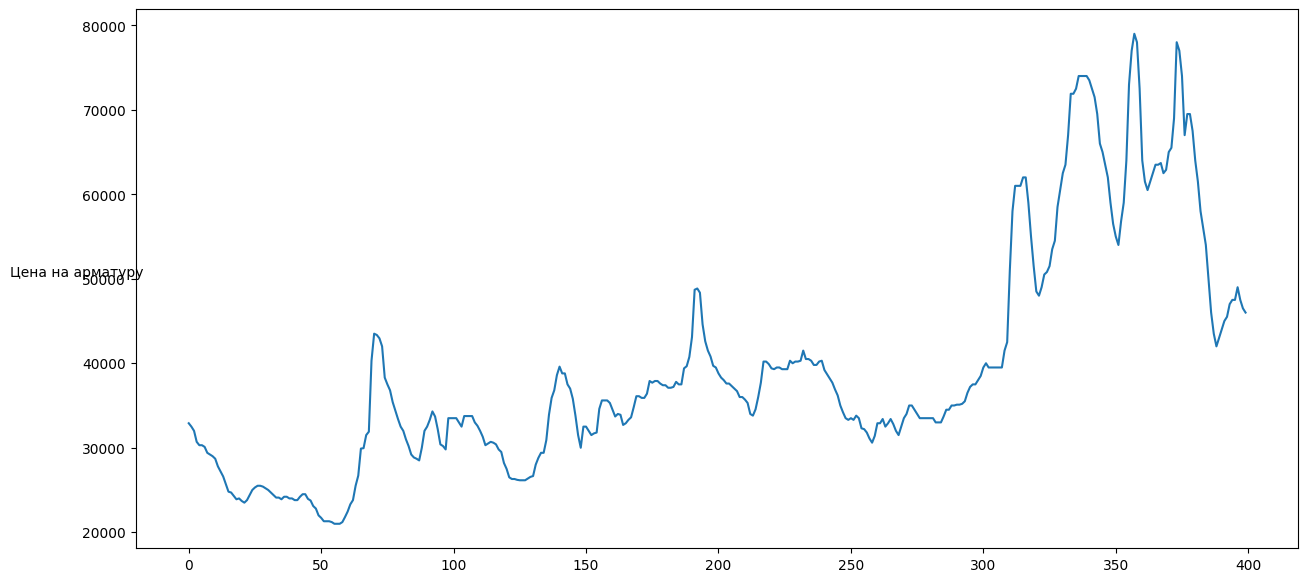

In [6]:
plt.figure(figsize=(15, 7))
plt.ylabel('Цена на арматуру', rotation=0)
df['Цена на арматуру'].plot()

Судя по графику, временной ряд случайный. Однако, можно предположить, что он все таки увеличивается. Чтобы не гадать, можно это проверить

In [7]:
!pip install statsmodels==0.14.4

In [8]:
df["Цена на арматуру"]

,Цена на арматуру
0,32900
1,32500
2,32000
3,30700
4,30300
...,...
395,47500
396,49000
397,47500
398,46500


In [9]:
df.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [10]:
df['Цена на арматуру'].describe()

,Цена на арматуру
count,400.000000
mean,39229.475000
std,13407.979668
min,21000.000000
25%,31075.000000
50%,35450.000000
75%,42000.000000
max,79000.000000


Приводим дату к формату даты и делаем её индексом

In [11]:
df['dt'] = pd.to_datetime(df['dt'], format='%m-%d-%Y')

df = df.set_index(['dt'])

Разложение ряда на компоненты

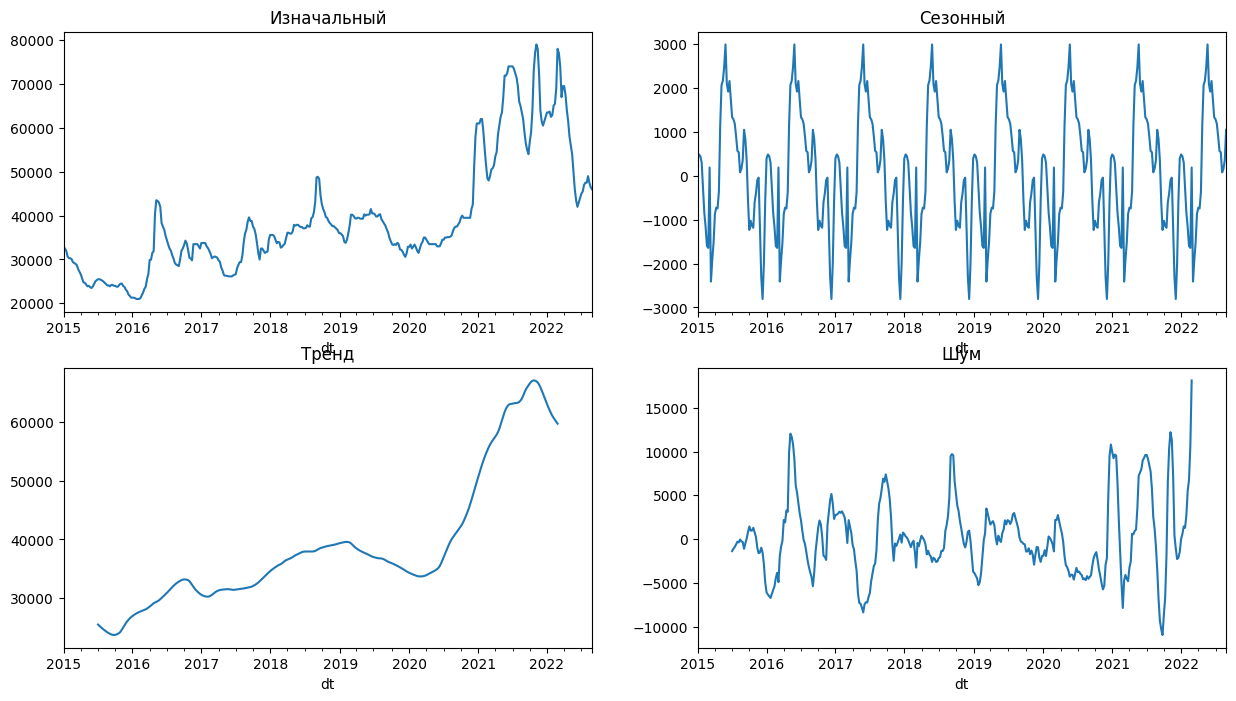

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

decompose = seasonal_decompose(df[['Цена на арматуру']])

ax[0, 0].set_title('Изначальный')
ax[0, 1].set_title('Сезонный')
ax[1, 0].set_title('Тренд')
ax[1, 1].set_title('Шум')

decompose.observed.plot(ax=ax[0, 0])
decompose.seasonal.plot(ax=ax[0, 1])
decompose.trend.plot(ax=ax[1, 0])
decompose.resid.plot(ax=ax[1, 1]);


Тест на стационарность

In [13]:
from statsmodels.tsa.stattools import adfuller, acf

result = adfuller(df['Цена на арматуру'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155


можно предположить, т.к. p > 0.05, что временной ряд нестационарен
Надо убрать тренд и сезонность

Автокорреляция и частичная автокорреляция

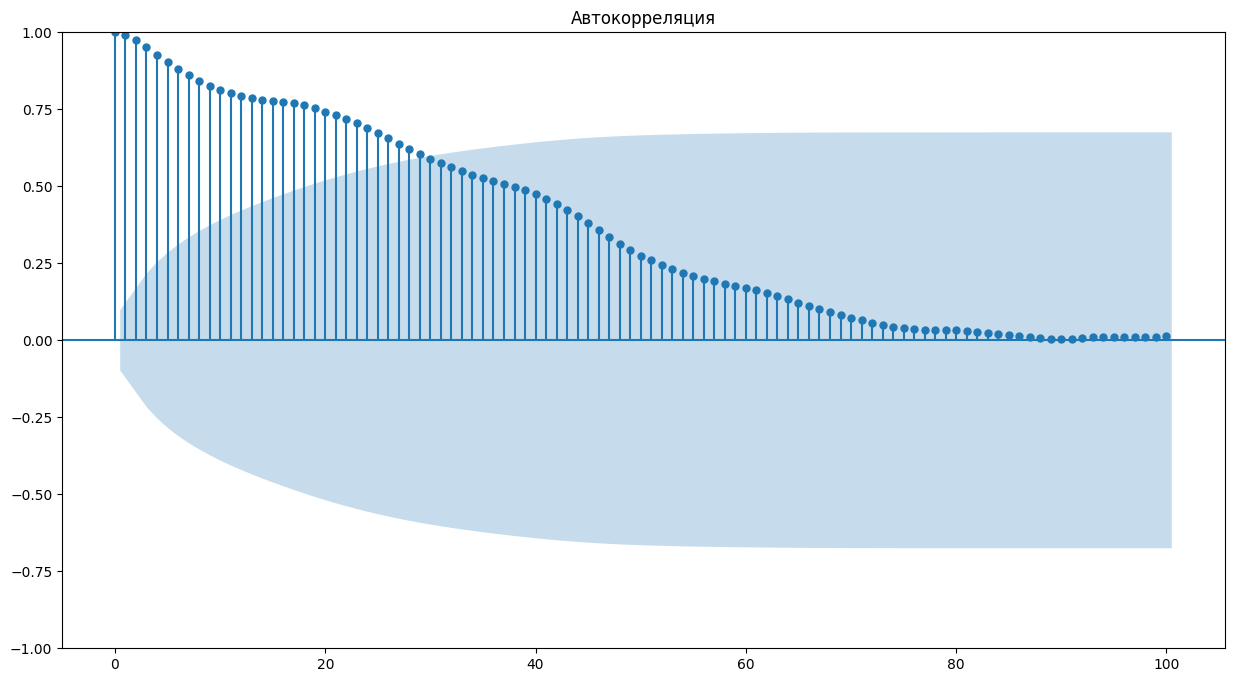

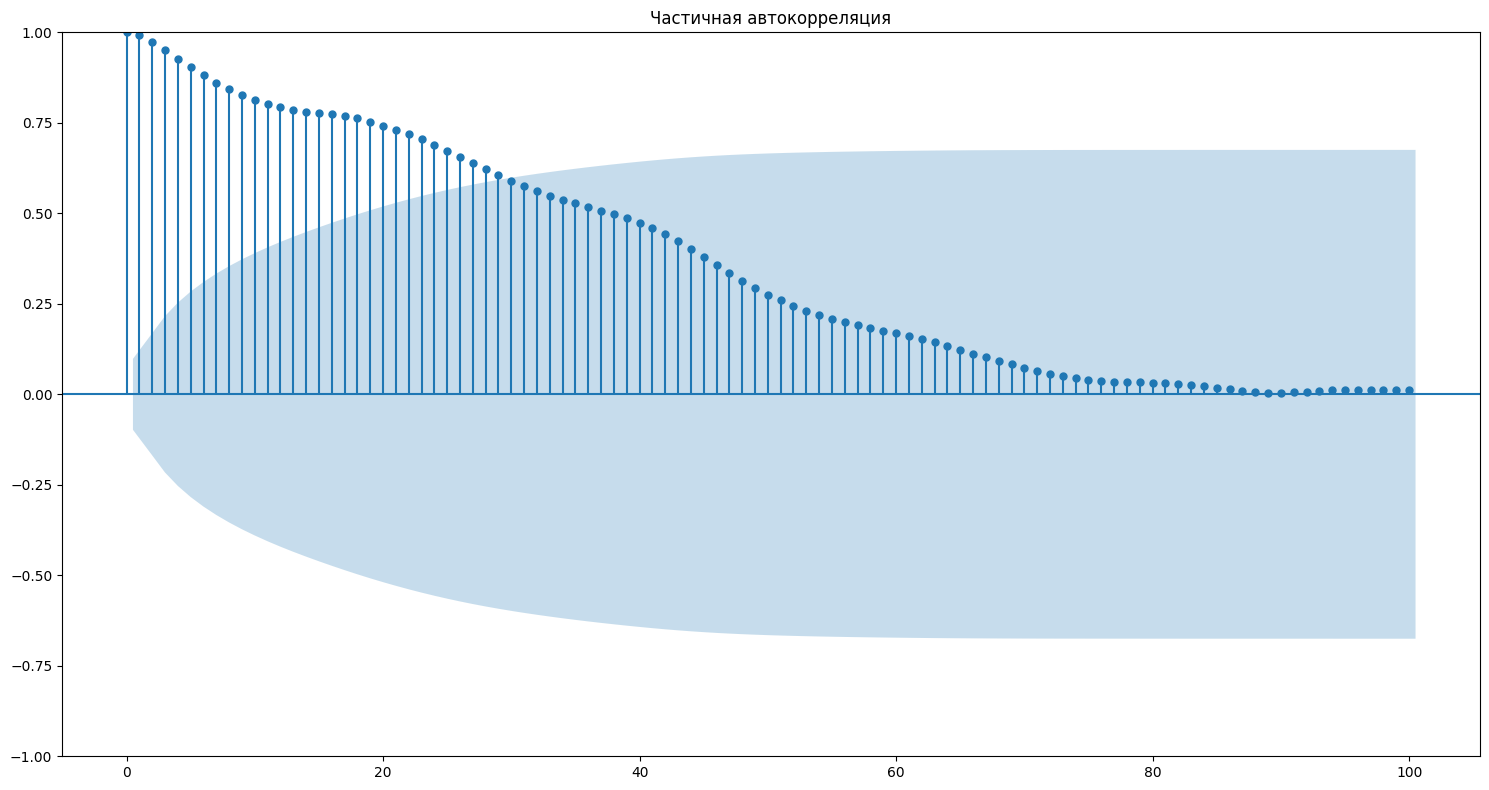

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15,8))
plot_acf(df['Цена на арматуру'], lags=100, ax=plt.gca())
plt.title('Автокорреляция')

plt.figure(figsize=(15,8))

plot_acf(df['Цена на арматуру'], lags=100, ax=plt.gca())
plt.title('Частичная автокорреляция')

plt.tight_layout()
plt.show()

Надо сделать временной ряд стационарным


модель ARIMA

Экспоненциальное сглаживание

In [15]:
alpha = 0.4

exp_smoothing = [df['Цена на арматуру'].iloc[0]]

for i in range(1, len(df['Цена на арматуру'])):
  exp_smoothing.append(alpha*df['Цена на арматуру'].iloc[i] + (1-alpha)*exp_smoothing[i-1])

print(exp_smoothing[-2])

47182.1182616193


In [16]:
from datetime import timedelta

last_day = df.iloc[[-1]].index

last_day = last_day + timedelta(days=1)

last_day


DatetimeIndex(['2022-08-30'], dtype='datetime64[ns]', name='dt', freq=None)

In [17]:
df

,Цена на арматуру
dt,
2015-01-05,32900
2015-01-12,32500
2015-01-19,32000
2015-01-26,30700
2015-02-02,30300
...,...
2022-08-01,47500
2022-08-08,49000
2022-08-15,47500


In [18]:
df.columns

Index(['Цена на арматуру'], dtype='object')

In [19]:
from statsmodels.tsa.ar_model import AutoReg

auto_reg_model = AutoReg(df, lags=[10, 100, 200], seasonal=True, period=12).fit()

auto_reg_model.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                AutoReg Model Results                                
=====================================================================================
Dep. Variable:              Цена на арматуру   No. Observations:                  400
Model:             Restr. Seas. AutoReg(200)   Log Likelihood               -2104.793
Method:                      Conditional MLE   S.D. of innovations           9000.413
Date:                       Wed, 19 Mar 2025   AIC                           4241.586
Time:                               11:06:58   BIC                           4294.359
Sample:                           11-05-2018   HQIC                          4262.942
                                - 08-29-2022                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2128.0336   6420.251     -0.331      0.740   -1.47e+04    1.05e+04
s(2,12)                 379.1582   3087.708      0.123      0.902   -5672.638    6430.955
s(3,12)                -105.0726   3087.970     -0.034      0.973   -6157.383    5947.238
s(4,12)                -752.9287   3089.739     -0.244      0.807   -6808.705    5302.848
s(5,12)               -1005.9230   3137.223     -0.321      0.748   -7154.767    5142.921
s(6,12)                -988.5368   3137.445     -0.315      0.753   -7137.816    5160.742
s(7,12)                -549.3147   3136.106     -0.175      0.861   -6695.969    5597.339
s(8,12)                -377.6945   3137.305     -0.120      0.904   -6526.700    5771.311
s(9,12)               -1049.9512   3090.642     -0.340      0.734   -7107.498    5007.595
s(10,12)              -1049.1331   3088.852     -0.340      0.734   -7103.171    5004.905
s(11,12)               -393.5990   3087.543     -0.127      0.899   -6445.071    5657.873
s(12,12)               -430.5881   3087.345     -0.139      0.889   -6481.673    5620.497
Цена на арматуру.L10      0.7345      0.052     14.246      0.000       0.633       0.836
Цена на арматуру.L100     0.3310      0.164      2.023      0.043       0.010       0.652
Цена на арматуру.L200     0.1170      0.122      0.958      0.338      -0.122       0.356
                                     Roots                                     
===============================================================================
                    Real          Imaginary           Modulus         Frequency
-------------------------------------------------------------------------------
AR.1             -0.8062           -0.5857j            0.9965           -0.4000
AR.2             -0.8062           +0.5857j            0.9965            0.4000
AR.3             -0.7760           -0.6336j            1.0019           -0.3910
AR.4             -0.7760           +0.6336j            1.0019            0.3910
AR.5             -0.7376           -0.6848j            1.0065           -0.3809
AR.6             -0.7376           +0.6848j            1.0065            0.3809
AR.7             -0.7627           -0.6690j            1.0146           -0.3854
AR.8             -0.7627           +0.6690j            1.0146            0.3854
AR.9             -0.8010           -0.6194j            1.0125           -0.3952
AR.10            -0.8010           +0.6194j            1.0125            0.3952
AR.11            -0.8424           -0.5422j            1.0019           -0.4090
AR.12            -0.8424           +0.5422j            1.0019            0.4090
AR.13            -0.8365           -0.5704j            1.0125           -0.4048
AR.14            -0.8365           +0.5704j            1.0125            0.4048
AR.15            -0.8793           -0.4899j            1.0065           -0.4191
AR.16            -0.8793           +0.

In [20]:
# df['exp_smoothing'] = exp_smoothing

# df.head(20)

LTSM

CatBoost

Кросс валидация

Выбросы
Чтобы улучшить качество модели, лучше их убрать, учитывая, что их не так уж и много

<Axes: >

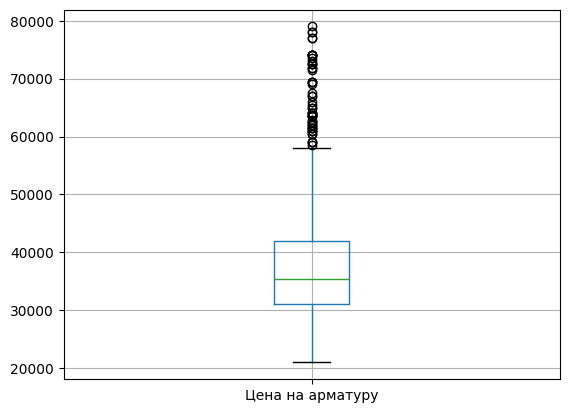

In [21]:
df.boxplot()

Разделение на обучающую и тестовую выборку

In [22]:

train_size = int(len(df)*0.7)
train, test = df[:train_size], df[train_size:]

print(f"Размер обучающей выборки: {train.shape}")
print(f"Размер тестовой выборки: {test.shape}")

Размер обучающей выборки: (280, 1)
Размер тестовой выборки: (120, 1)


In [23]:
train

,Цена на арматуру
dt,
2015-01-05,32900
2015-01-12,32500
2015-01-19,32000
2015-01-26,30700
2015-02-02,30300
...,...
2020-04-13,34000
2020-04-20,33500
2020-04-27,33500


In [24]:
test

,Цена на арматуру
dt,
2020-05-18,33500
2020-05-25,33500
2020-06-01,33000
2020-06-08,33000
2020-06-15,33000
...,...
2022-08-01,47500
2022-08-08,49000
2022-08-15,47500


Добавление лагов

In [25]:
for lag in range(1, 10):
  train[f'lag_{lag}'] = train['Цена на арматуру'].shift(lag)
  test[f'lag_{lag}'] = test['Цена на арматуру'].shift(lag)


<ipython-input-25-2908a69f314f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'lag_{lag}'] = train['Цена на арматуру'].shift(lag)
<ipython-input-25-2908a69f314f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'lag_{lag}'] = test['Цена на арматуру'].shift(lag)
<ipython-input-25-2908a69f314f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [26]:
train.dropna(inplace=True)
test.dropna(inplace=True)

<ipython-input-26-1dff8fd905b1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)
<ipython-input-26-1dff8fd905b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.dropna(inplace=True)


In [27]:
train

,Цена на арматуру,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
dt,,,,,,,,,,
2015-03-09,29000,29200.0,29400.0,30100.0,30300.0,30300.0,30700.0,32000.0,32500.0,32900.0
2015-03-16,28700,29000.0,29200.0,29400.0,30100.0,30300.0,30300.0,30700.0,32000.0,32500.0
2015-03-23,27800,28700.0,29000.0,29200.0,29400.0,30100.0,30300.0,30300.0,30700.0,32000.0
2015-03-30,27200,27800.0,28700.0,29000.0,29200.0,29400.0,30100.0,30300.0,30300.0,30700.0
2015-04-06,26600,27200.0,27800.0,28700.0,29000.0,29200.0,29400.0,30100.0,30300.0,30300.0
...,...,...,...,...,...,...,...,...,...,...
2020-04-13,34000,34500.0,35000.0,35000.0,34000.0,33500.0,32500.0,31500.0,32000.0,32800.0
2020-04-20,33500,34000.0,34500.0,35000.0,35000.0,34000.0,33500.0,32500.0,31500.0,32000.0
2020-04-27,33500,33500.0,34000.0,34500.0,35000.0,35000.0,34000.0,33500.0,32500.0,31500.0


In [28]:
test

,Цена на арматуру,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
dt,,,,,,,,,,
2020-07-20,35000,35000.0,34500.0,34500.0,33700.0,33000.0,33000.0,33000.0,33500.0,33500.0
2020-07-27,35100,35000.0,35000.0,34500.0,34500.0,33700.0,33000.0,33000.0,33000.0,33500.0
2020-08-03,35100,35100.0,35000.0,35000.0,34500.0,34500.0,33700.0,33000.0,33000.0,33000.0
2020-08-10,35200,35100.0,35100.0,35000.0,35000.0,34500.0,34500.0,33700.0,33000.0,33000.0
2020-08-17,35500,35200.0,35100.0,35100.0,35000.0,35000.0,34500.0,34500.0,33700.0,33000.0
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,47500,47500.0,47000.0,45500.0,45000.0,44000.0,43000.0,42000.0,43500.0,46000.0
2022-08-08,49000,47500.0,47500.0,47000.0,45500.0,45000.0,44000.0,43000.0,42000.0,43500.0
2022-08-15,47500,49000.0,47500.0,47500.0,47000.0,45500.0,45000.0,44000.0,43000.0,42000.0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400 entries, 2015-01-05 to 2022-08-29
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Цена на арматуру  400 non-null    int64
dtypes: int64(1)
memory usage: 6.2 KB


Временные признаки

In [30]:
train['year'] = train.index.year
train['month'] = train.index.month
train['day'] = train.index.day
train['dayofweek'] = train.index.dayofweek

test['year'] = test.index.year
test['month'] = test.index.month
test['day'] = test.index.day
test['dayofweek'] = test.index.dayofweek

<ipython-input-30-661a6644ae69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['year'] = train.index.year
<ipython-input-30-661a6644ae69>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['month'] = train.index.month
<ipython-input-30-661a6644ae69>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

Разделение на тестовую и обучающую с признаками

In [31]:
features = [f'lag_{lag}' for lag in range(1, 10)] + ['year', 'month', 'day', 'dayofweek']
X_train = train[features]
Y_train = train['Цена на арматуру']
X_test = test[features]
Y_test = test['Цена на арматуру']

Почему-то CatBoost с Numpy не хотят совмещаться:(((((

In [32]:
!pip install numpy==1.23.5 catboost==1.2

0:	learn: 5686.7027429	test: 26457.1059480	best: 26457.1059480 (0)	total: 47.1ms	remaining: 23.5s
100:	learn: 1230.5872655	test: 17762.9123708	best: 17760.1439194 (99)	total: 114ms	remaining: 451ms
200:	learn: 882.2502549	test: 16500.8077499	best: 16500.8077499 (200)	total: 155ms	remaining: 231ms
300:	learn: 746.2242391	test: 16101.0256519	best: 16096.5040019 (292)	total: 193ms	remaining: 128ms
400:	learn: 646.8301452	test: 16054.6694512	best: 16051.2393030 (386)	total: 242ms	remaining: 59.8ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 16051.2393
bestIteration = 386

Shrink model to first 387 iterations.
Mean Squared Error (MSE): 257642283.1630
Root Mean Squared Error (RMSE): 16051.2393
R²: -0.6584


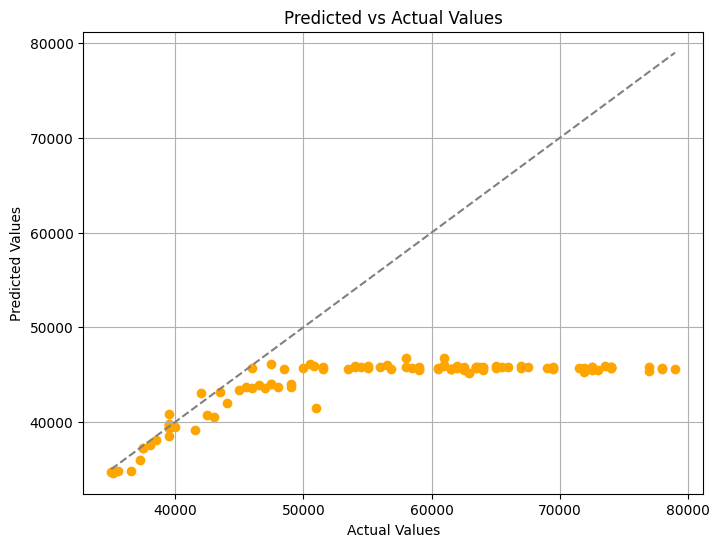

In [33]:

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score




catboost_regressor_model = CatBoostRegressor(
    iterations=500,  # кол.итераций
    learning_rate=0.05,  # скорость обучения
    depth=3,  # глубина деревьев
    l2_leaf_reg=5,  # регулярзация
    eval_metric='RMSE', # метрика
    early_stopping_rounds=50,
    verbose=100
)

catboost_regressor_model.fit(X_train, Y_train, eval_set=(X_test, Y_test))

Y_pred = catboost_regressor_model.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
rmse = mse ** 0.5


r2 = r2_score(Y_test, Y_pred)


print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R²: {r2:.4f}')


plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, color='orange')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], linestyle='--', color='gray')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.grid()
plt.show()

Надо улучшить показатели модели, привести ряд к стационарному виду, возможно избавиться от выбросов и предсказать на сколько там недель закупать арматуру

Поиск лучших параметров для модели

In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [3, 5, 7, 10],
    'iterations': [500, 1000]
}

grid_search = GridSearchCV(estimator=catboost_regressor_model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, Y_train, eval_set=(X_test, Y_test))
print(grid_search.best_params_)

0:	learn: 4278.1804476	test: 24509.8313208	best: 24509.8313208 (0)	total: 498us	remaining: 249ms
100:	learn: 2453.9781675	test: 21942.3121094	best: 21942.3121094 (100)	total: 29.3ms	remaining: 116ms
200:	learn: 1673.6794878	test: 20160.9660320	best: 20160.9660320 (200)	total: 57.5ms	remaining: 85.6ms
300:	learn: 1313.8039224	test: 19166.8009597	best: 19166.8009597 (300)	total: 85.5ms	remaining: 56.5ms
400:	learn: 1100.3363594	test: 18604.9657002	best: 18604.9657002 (400)	total: 121ms	remaining: 29.9ms
499:	learn: 959.4163708	test: 18287.3451783	best: 18287.3451783 (499)	total: 149ms	remaining: 0us

bestTest = 18287.34518
bestIteration = 499

0:	learn: 6633.7593731	test: 26958.4670986	best: 26958.4670986 (0)	total: 505us	remaining: 252ms
100:	learn: 3399.1892847	test: 22987.1341716	best: 22987.1341716 (100)	total: 41.6ms	remaining: 164ms
200:	learn: 2173.2017507	test: 20906.2359252	best: 20906.2359252 (200)	total: 91.2ms	remaining: 136ms
300:	learn: 1658.7974523	test: 19614.7257132	best

Модель очень плохо обучена, возможно ей надо добавить признаки. Для этого воспользуемся еще одной таблицей с ценами на сырье

In [35]:

df_raw_material_price = pd.read_excel('/content/drive/MyDrive/ML_3/Цены на сырье.xlsx')

df_raw_material_price.head()

,dt,"Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","ЖРС_Китай Iron ore fines Fe 62%, CFR","Чугун_CFR Италия, $/т","Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС","ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т",...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
0,2015-02-09,3850,228,12344,10009,12728,62,NaN,3700.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-02-16,3850,206,12271,10432,12852,63,NaN,3700.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-02-23,3850,207,12645,11981,13034,64,NaN,3700.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-03-02,3850,214,12696,11912,12910,63,NaN,3700.0,72.0,...,NaN,NaN,3540.0,2097.0,1261.0,23.0,NaN,NaN,NaN,NaN
4,2015-03-09,4400,232,12916,12061,12964,61,NaN,4050.0,70.0,...,NaN,NaN,3540.0,2097.0,1261.0,23.0,NaN,NaN,NaN,NaN


In [36]:
df_raw_material_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 59 columns):
 #   Column                                                                                            Non-Null Count  Dtype         
---  ------                                                                                            --------------  -----         
 0   dt                                                                                                423 non-null    datetime64[ns]
 1   Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС                                  423 non-null    int64         
 2   Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т                                                          423 non-null    int64         
 3   Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС                                                      423 non-null    int64         
 4   Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС                                      

Получилась полосатая зебра

<Axes: >

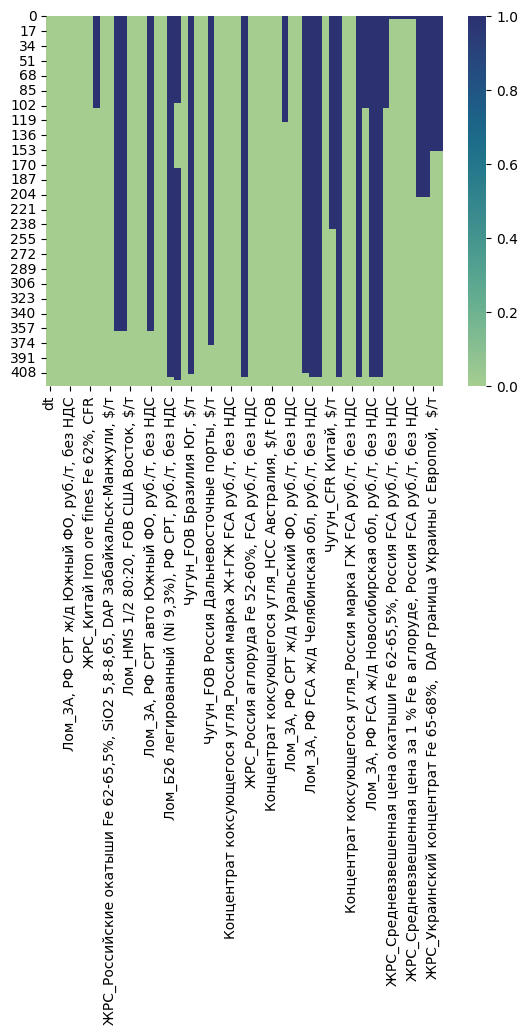

In [37]:
sns.heatmap(df_raw_material_price.isnull(), cmap='crest')

In [42]:
df_raw_material_price.columns

Index(['dt',
       'Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС',
       'Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т',
       'Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС',
       'Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС',
       'Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС',
       'ЖРС_Китай Iron ore fines Fe 62%, CFR', 'Чугун_CFR Италия, $/т',
       'Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС',
       'ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т',
       'Лом_3А, РФ CPT авто Центральный ФО, руб./т, без НДС',
       'Лом_3А, РФ CPT авто Уральский ФО, руб./т, без НДС',
       'Лом_HMS 1/2 80:20, FOB США Восток, $/т',
       'Лом_3А, FOB РФ Черное море, $/т', 'Чугун_FOB Бразилия Север, $/т',
       'Лом_3А, РФ CPT авто Южный ФО, руб./т, без НДС',
       'Лом_HMS 1/2 80:20, CFR ЮВА, $/т',
       'Концентрат коксующегося угля_Россия марка КС FCA руб./т, без НДС',
       'Лом_Б26 легированный (

In [43]:
df_raw_material_price['dt'] = pd.to_datetime(df_raw_material_price['dt'], format='%m-%d-%Y')

df_raw_material_price = df_raw_material_price.set_index(['dt'])

In [44]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

for column in df_raw_material_price.columns:
  df_raw_material_price[column] = imputer.fit_transform(df_raw_material_price[[column]])


df_raw_material_price

,"Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","ЖРС_Китай Iron ore fines Fe 62%, CFR","Чугун_CFR Италия, $/т","Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС","ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т","Лом_3А, РФ CPT авто Центральный ФО, руб./т, без НДС",...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
dt,,,,,,,,,,,,,,,,,,,,,
2015-02-09,3850.0,228.0,12344.0,10009.0,12728.0,62.0,431.336478,3700.0,70.0,22428.225806,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-02-16,3850.0,206.0,12271.0,10432.0,12852.0,63.0,431.336478,3700.0,70.0,22428.225806,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-02-23,3850.0,207.0,12645.0,11981.0,13034.0,64.0,431.336478,3700.0,72.0,22428.225806,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-03-02,3850.0,214.0,12696.0,11912.0,12910.0,63.0,431.336478,3700.0,72.0,22428.225806,...,21682.5,418.937107,3540.000000,2097.000000,1261.000000,23.000000,93.523148,133.078704,108.363806,149.309701
2015-03-09,4400.0,232.0,12916.0,12061.0,12964.0,61.0,431.336478,4050.0,70.0,22428.225806,...,21682.5,418.937107,3540.000000,2097.000000,1261.000000,23.000000,93.523148,133.078704,108.363806,149.309701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-13,9500.0,399.0,25741.0,23774.0,24100.0,124.0,505.000000,7500.0,136.5,22600.000000,...,22765.0,457.500000,5043.000000,4382.000000,2577.000000,50.000000,66.000000,78.000000,116.000000,154.000000
2023-02-20,9500.0,390.0,25837.0,24060.0,24184.0,124.0,500.000000,7500.0,137.5,22550.000000,...,23414.0,465.000000,5043.000000,4382.000000,2577.000000,50.000000,66.000000,78.000000,116.000000,154.000000
2023-02-27,9500.0,411.0,25814.0,24275.0,24047.0,130.0,502.500000,7500.0,143.0,22400.000000,...,24014.0,455.000000,5547.000000,4898.000000,2921.000000,56.000000,74.000000,85.000000,122.000000,159.000000


<Axes: ylabel='dt'>

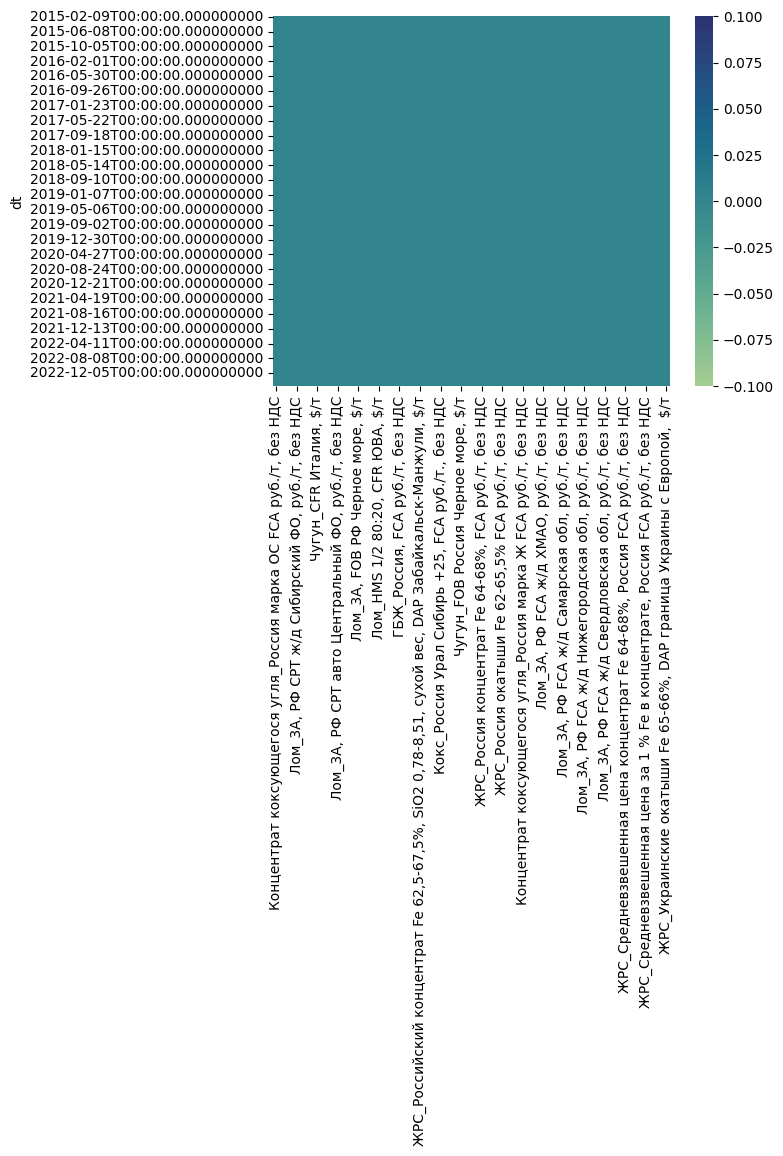

In [45]:
sns.heatmap(df_raw_material_price.isnull(), cmap='crest')

Склеиваем наши новоиспеченные признаки и основной датафрейм

Теперь надо объединить эти два датафрейма в один, чтобы иметь доступ к новым признакам

In [53]:
df_raw_material_price.index

DatetimeIndex(['2015-02-09', '2015-02-16', '2015-02-23', '2015-03-02',
               '2015-03-09', '2015-03-16', '2015-03-23', '2015-03-30',
               '2015-04-06', '2015-04-13',
               ...
               '2023-01-09', '2023-01-16', '2023-01-23', '2023-01-30',
               '2023-02-06', '2023-02-13', '2023-02-20', '2023-02-27',
               '2023-03-06', '2023-03-13'],
              dtype='datetime64[ns]', name='dt', length=423, freq=None)

<Axes: ylabel='dt'>

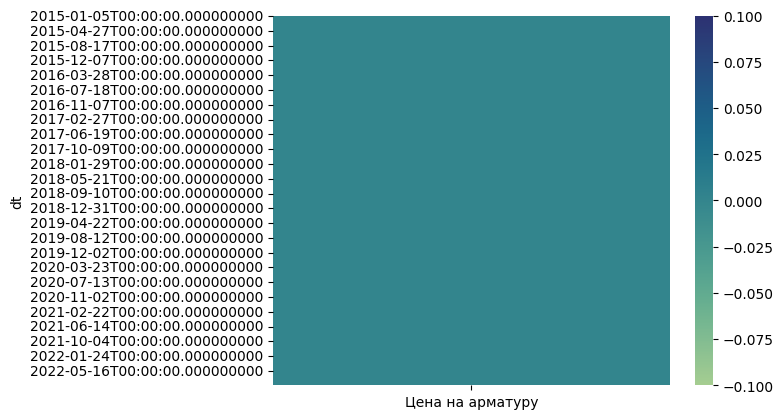

In [55]:
sns.heatmap(df.isnull(), cmap='crest')

In [54]:
df.index

DatetimeIndex(['2015-01-05', '2015-01-12', '2015-01-19', '2015-01-26',
               '2015-02-02', '2015-02-09', '2015-02-16', '2015-02-23',
               '2015-03-02', '2015-03-09',
               ...
               '2022-06-27', '2022-07-04', '2022-07-11', '2022-07-18',
               '2022-07-25', '2022-08-01', '2022-08-08', '2022-08-15',
               '2022-08-22', '2022-08-29'],
              dtype='datetime64[ns]', name='dt', length=400, freq=None)

In [56]:

merged_df = df.join(df_raw_material_price, how='outer')

merged_df

,Цена на арматуру,"Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","ЖРС_Китай Iron ore fines Fe 62%, CFR","Чугун_CFR Италия, $/т","Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС","ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т",...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
dt,,,,,,,,,,,,,,,,,,,,,
2015-01-05,32900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-12,32500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-19,32000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-26,30700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-02,30300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-13,NaN,9500.0,399.0,25741.0,23774.0,24100.0,124.0,505.0,7500.0,136.5,...,22765.0,457.5,5043.0,4382.0,2577.0,50.0,66.0,78.0,116.0,154.0
2023-02-20,NaN,9500.0,390.0,25837.0,24060.0,24184.0,124.0,500.0,7500.0,137.5,...,23414.0,465.0,5043.0,4382.0,2577.0,50.0,66.0,78.0,116.0,154.0
2023-02-27,NaN,9500.0,411.0,25814.0,24275.0,24047.0,130.0,502.5,7500.0,143.0,...,24014.0,455.0,5547.0,4898.0,2921.0,56.0,74.0,85.0,122.0,159.0


<Axes: ylabel='dt'>

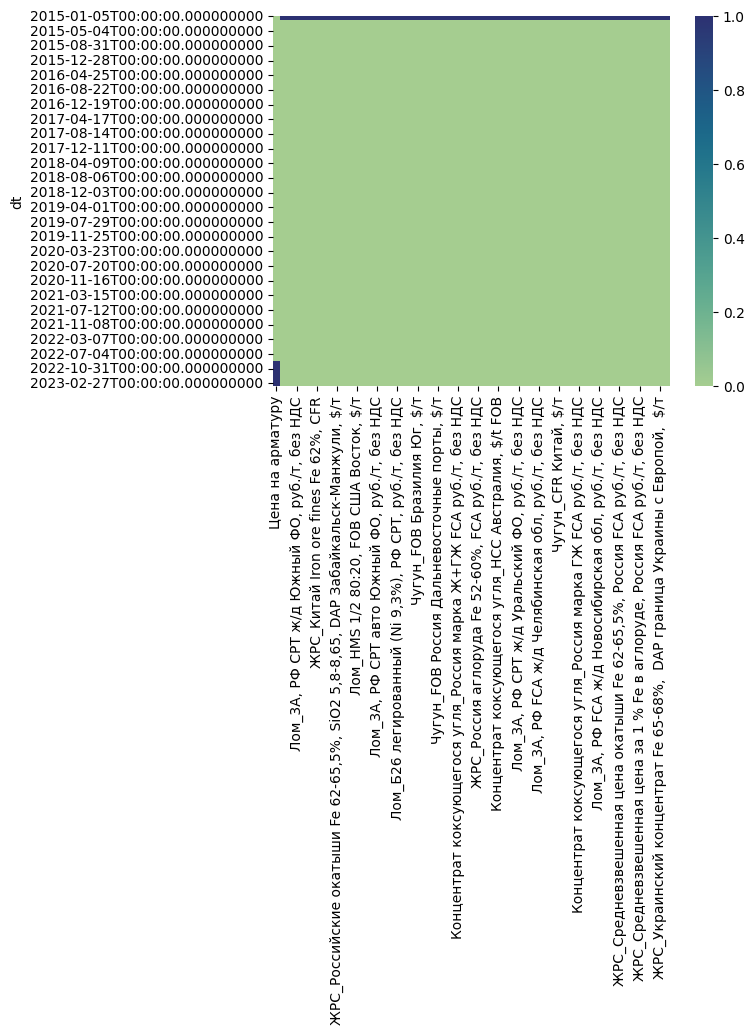

In [57]:
sns.heatmap(merged_df.isnull(), cmap='crest')

In [61]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 428 entries, 2015-01-05 to 2023-03-13
Data columns (total 59 columns):
 #   Column                                                                                            Non-Null Count  Dtype  
---  ------                                                                                            --------------  -----  
 0   Цена на арматуру                                                                                  400 non-null    float64
 1   Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС                                  423 non-null    float64
 2   Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т                                                          423 non-null    float64
 3   Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС                                                      423 non-null    float64
 4   Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС                                                  423 non-nul

Еще раз заполняем данные

In [63]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

for column in merged_df.columns:
  merged_df[column] = imputer.fit_transform(merged_df[[column]])


merged_df

,Цена на арматуру,"Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","ЖРС_Китай Iron ore fines Fe 62%, CFR","Чугун_CFR Италия, $/т","Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС","ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т",...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
dt,,,,,,,,,,,,,,,,,,,,,
2015-01-05,32900.000,8615.898345,299.574468,18144.458629,16368.888889,17777.297872,93.07565,431.336478,7163.416076,113.814421,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-01-12,32500.000,8615.898345,299.574468,18144.458629,16368.888889,17777.297872,93.07565,431.336478,7163.416076,113.814421,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-01-19,32000.000,8615.898345,299.574468,18144.458629,16368.888889,17777.297872,93.07565,431.336478,7163.416076,113.814421,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-01-26,30700.000,8615.898345,299.574468,18144.458629,16368.888889,17777.297872,93.07565,431.336478,7163.416076,113.814421,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-02-02,30300.000,8615.898345,299.574468,18144.458629,16368.888889,17777.297872,93.07565,431.336478,7163.416076,113.814421,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-13,39229.475,9500.000000,399.000000,25741.000000,23774.000000,24100.000000,124.00000,505.000000,7500.000000,136.500000,...,22765.0,457.500000,5043.000000,4382.000000,2577.000000,50.000000,66.000000,78.000000,116.000000,154.000000
2023-02-20,39229.475,9500.000000,390.000000,25837.000000,24060.000000,24184.000000,124.00000,500.000000,7500.000000,137.500000,...,23414.0,465.000000,5043.000000,4382.000000,2577.000000,50.000000,66.000000,78.000000,116.000000,154.000000
2023-02-27,39229.475,9500.000000,411.000000,25814.000000,24275.000000,24047.000000,130.00000,502.500000,7500.000000,143.000000,...,24014.0,455.000000,5547.000000,4898.000000,2921.000000,56.000000,74.000000,85.000000,122.000000,159.000000


Снова проделываем те же операции по разделению обучающей и тестовой выборки

In [ ]:
train_size = int(len(df)*0.7)
train, test = merged_df[:train_size], merged_df[train_size:]

print(f"Размер обучающей выборки: {train.shape}")
print(f"Размер тестовой выборки: {test.shape}")

ну а дальше то же самое и протестировать модель но уже с новыми признаками